# Modelo preditivo usando TensorFlow

### Referências

https://www.tensorflow.org/tutorials/audio/simple_audio#run_inference_on_an_audio_file

https://stackoverflow.com/questions/46508055/using-ffmpeg-to-cut-audio-from-to-position

https://superuser.com/questions/650291/how-to-get-video-duration-in-seconds

In [1]:
import os
import pathlib

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import tensorflow as tf

from tensorflow.keras.layers.experimental import preprocessing
from tensorflow.keras import layers
from tensorflow.keras import models
from IPython import display
import IPython.display as ipd

SEED = 42
tf.random.set_seed(SEED)
np.random.seed(SEED)

In [2]:
# diretório de entrada
DIR_ENTRADA = 'wavbal5'

# duração de cada trecho de áudio
DURACAO_TRECHO = 5 # segundos

# sampling rate
SAMPLE_RATE = 16000 # 16 kHz

# total de pontos de onda no áudio
PONTOS_ONDA = SAMPLE_RATE * DURACAO_TRECHO # 16 kHz * 5 s = 80000

## Carregar arquivos de áudio

In [3]:
data_dir = pathlib.Path(DIR_ENTRADA)
#data_dir = pathlib.Path('wav')
data_dir

PosixPath('wavbal5')

In [4]:
especies = np.array(tf.io.gfile.listdir(str(data_dir)))
#especies = especies[especies != 'README.md']
#especies2 = [x.replace('_', ' ') for x in especies.tolist()]
print('Espécies:', especies.tolist())

Espécies: ['mimus_saturninus', 'ramphocelus_carbo', 'columba_livia', 'turdus_leucomelas', 'caracara_plancus', 'megarynchus_pitangua', 'vanellus_chilensis', 'pitangus_sulphuratus', 'turdus_rufiventris', 'furnarius_rufus', 'theristicus_caudatus']


In [6]:
filenames = tf.io.gfile.glob(str(data_dir) + '/*/*.wav')
#filenames = tf.io.gfile.glob(str(data_dir) + '/*/*')
filenames = tf.random.shuffle(filenames)
num_samples = len(filenames)

print('Número total de amostras:', num_samples)
print('Número de amostras por espécie:',
      len(tf.io.gfile.listdir(str(data_dir / especies[0]))))
print('Exemplo de arquivo do tensor:\n ', filenames[0])

Número total de amostras: 35770
Número de amostras por espécie: 3561
Exemplo de arquivo do tensor:
  tf.Tensor(b'wavbal5/ramphocelus_carbo/Ramphocelus505434-3-2.wav', shape=(), dtype=string)


In [7]:
PCT_TRAINING = 0.8
PCT_VALIDATION = 0.1

train_rows = int(num_samples * PCT_TRAINING)
val_rows = int(num_samples * PCT_VALIDATION)
test_rows = num_samples - (train_rows + val_rows)

In [8]:
train_files = filenames[:train_rows]
val_files = filenames[train_rows : train_rows + val_rows]
test_files = filenames[-test_rows:]

print('Training set size..:', len(train_files))
print('Validation set size:', len(val_files))
print('Test set size......:', len(test_files))

Training set size..: 28616
Validation set size: 3577
Test set size......: 3577


In [9]:
def decode_audio(audio_binary):
    audio, _ = tf.audio.decode_wav(audio_binary)
    return tf.squeeze(audio, axis=-1)

In [10]:
def get_label(file_path):
    parts = tf.strings.split(file_path, os.path.sep)

    # Note: You'll use indexing here instead of tuple
    # unpacking to enable this to work in a TensorFlow graph.
    return parts[-2]

In [11]:
def get_waveform_and_label(file_path):
    label = get_label(file_path)
    audio_binary = tf.io.read_file(file_path)
    waveform = decode_audio(audio_binary)
    return waveform, label

In [12]:
AUTOTUNE = tf.data.AUTOTUNE
files_ds = tf.data.Dataset.from_tensor_slices(train_files)
waveform_ds = files_ds.map(get_waveform_and_label, num_parallel_calls=AUTOTUNE)

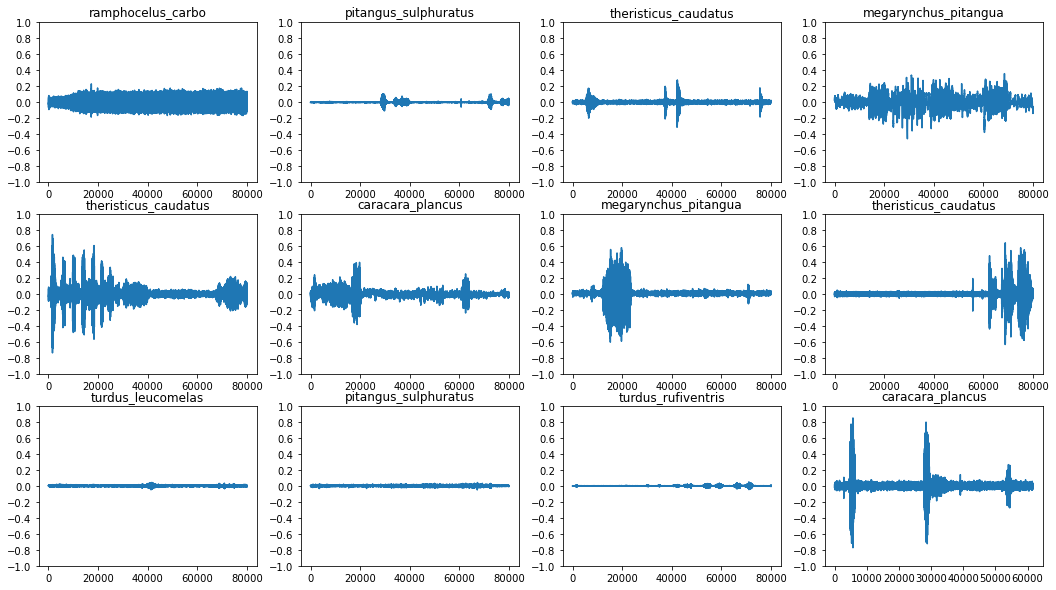

In [13]:
rows = 3
cols = 4
n = rows * cols
fig, axes = plt.subplots(rows, cols, figsize=(18, 10))

for i, (audio, label) in enumerate(waveform_ds.take(n)):
    r = i // cols
    c = i % cols
    ax = axes[r][c]
    ax.plot(audio.numpy())
    ax.set_yticks(np.arange(-1.0, 1.2, 0.2))
    label = label.numpy().decode('utf-8')
    ax.set_title(label)

plt.show()

In [14]:
def get_spectrogram(waveform):
    #print("tf.shape:", tf.shape(waveform))
    #return 0

    # Padding for files with less than 16000 samples
    zero_padding = tf.zeros([PONTOS_ONDA] - tf.shape(waveform), dtype=tf.float32)
    #zero_padding = tf.zeros([80000] - tf.shape(waveform), dtype=tf.float32) # 5 segundos

    # Concatenate audio with padding so that all
    # audio clips will be of the same length
    waveform = tf.cast(waveform, tf.float32)
    equal_length = tf.concat([waveform, zero_padding], 0)
    spectrogram = tf.signal.stft(equal_length, frame_length=255, frame_step=128)
    spectrogram = tf.abs(spectrogram)

    return spectrogram

In [15]:
for waveform, label in waveform_ds.take(1):
    label = label.numpy().decode('utf-8')
    spectrogram = get_spectrogram(waveform)

print('Label:', label)
print('Waveform shape:', waveform.shape)
print('Spectrogram shape:', spectrogram.shape)
print('Audio playback')

display.display(display.Audio(waveform, rate=16000))

Label: ramphocelus_carbo
Waveform shape: (80000,)
Spectrogram shape: (624, 129)
Audio playback


<ipython-input-16-d55d8e6bcdb2>:9: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  ax.pcolormesh(X, Y, log_spec)


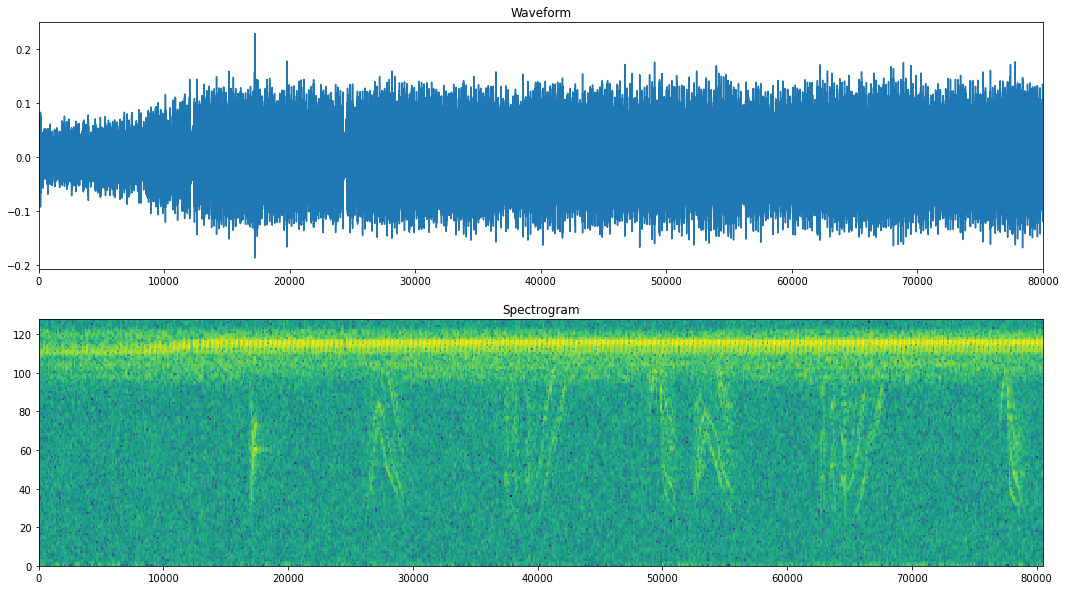

In [16]:
def plot_spectrogram(spectrogram, ax):
    # Convert to frequencies to log scale and transpose so that the time is
    # represented in the x-axis (columns).
    log_spec = np.log(spectrogram.T)
    height = log_spec.shape[0]
    width = log_spec.shape[1]
    X = np.linspace(0, np.size(spectrogram), num=width, dtype=int)
    Y = range(height)
    ax.pcolormesh(X, Y, log_spec)

fig, axes = plt.subplots(2, figsize=(18, 10))
timescale = np.arange(waveform.shape[0])
axes[0].plot(timescale, waveform.numpy())
axes[0].set_title('Waveform')
axes[0].set_xlim([0, PONTOS_ONDA])
#axes[0].set_xlim([0, 80000])
plot_spectrogram(spectrogram.numpy(), axes[1])
axes[1].set_title('Spectrogram')
plt.show()

In [17]:
def get_spectrogram_and_label_id(audio, label):
    spectrogram = get_spectrogram(audio)
    spectrogram = tf.expand_dims(spectrogram, -1)
    label_id = tf.argmax(label == especies)
    return spectrogram, label_id

In [18]:
spectrogram_ds = waveform_ds.map(get_spectrogram_and_label_id, num_parallel_calls=AUTOTUNE)
spectrogram_ds

<ParallelMapDataset shapes: ((None, 129, 1), ()), types: (tf.float32, tf.int64)>

<ipython-input-16-d55d8e6bcdb2>:9: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  ax.pcolormesh(X, Y, log_spec)


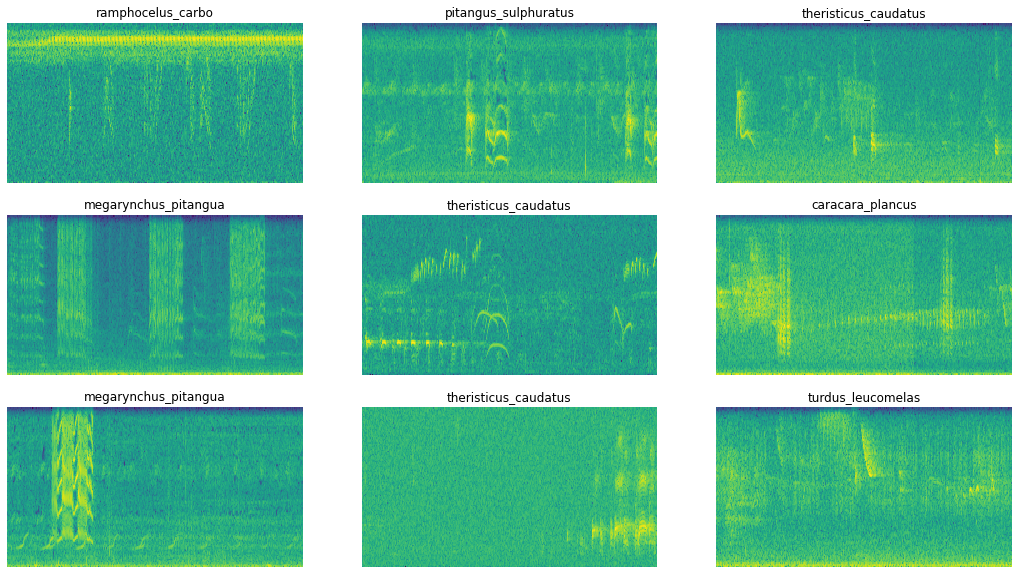

In [19]:
rows = 3
cols = 3
n = rows * cols
fig, axes = plt.subplots(rows, cols, figsize=(18, 10))

for i, (spectrogram, label_id) in enumerate(spectrogram_ds.take(n)):
    #print(i, label_id, label_id.numpy(), especies[label_id.numpy()])
    r = i // cols
    c = i % cols
    ax = axes[r][c]
    plot_spectrogram(np.squeeze(spectrogram.numpy()), ax)
    ax.set_title(especies[label_id.numpy()])
    ax.axis('off')

plt.show()

In [20]:
def preprocess_dataset(files):
    files_ds = tf.data.Dataset.from_tensor_slices(files)
    output_ds = files_ds.map(get_waveform_and_label, num_parallel_calls=AUTOTUNE)
    output_ds = output_ds.map(get_spectrogram_and_label_id, num_parallel_calls=AUTOTUNE)
    return output_ds

In [21]:
train_ds = spectrogram_ds
val_ds = preprocess_dataset(val_files)
test_ds = preprocess_dataset(test_files)

In [22]:
batch_size = 64
train_ds = train_ds.batch(batch_size)
val_ds = val_ds.batch(batch_size)

In [23]:
train_ds = train_ds.cache().prefetch(AUTOTUNE)
val_ds = val_ds.cache().prefetch(AUTOTUNE)

In [24]:
for spectrogram, _ in spectrogram_ds.take(1):
    input_shape = spectrogram.shape
print('Input shape:', input_shape)
num_labels = len(especies)

norm_layer = preprocessing.Normalization()
norm_layer.adapt(spectrogram_ds.map(lambda x, _: x))

model = models.Sequential([
    layers.InputLayer(input_shape=input_shape),
    #layers.Input(shape=input_shape),
    preprocessing.Resizing(32, 32), 
    norm_layer,
    layers.Conv2D(32, 3, activation='relu'),
    layers.Conv2D(64, 3, activation='relu'),
    layers.MaxPooling2D(),
    layers.Dropout(0.25),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(num_labels),
])

model.summary()

Input shape: (624, 129, 1)
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resizing (Resizing)          (None, 32, 32, 1)         0         
_________________________________________________________________
normalization (Normalization (None, 32, 32, 1)         3         
_________________________________________________________________
conv2d (Conv2D)              (None, 30, 30, 32)        320       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 28, 28, 64)        18496     
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 14, 14, 64)        0         
_________________________________________________________________
dropout (Dropout)            (None, 14, 14, 64)        0         
_________________________________________________________________
flatten (Flatten)            

In [25]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy']
)

In [26]:
%%time

EPOCHS = 15
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=EPOCHS,
    callbacks=tf.keras.callbacks.EarlyStopping(verbose=1, patience=2)
)

Epoch 1/15
448/448 [==============================] - 82s 182ms/step - loss: 1.5233 - accuracy: 0.4905 - val_loss: 1.1516 - val_accuracy: 0.6108
Epoch 2/15
448/448 [==============================] - 18s 40ms/step - loss: 1.1492 - accuracy: 0.6092 - val_loss: 1.0275 - val_accuracy: 0.6424
Epoch 3/15
448/448 [==============================] - 18s 40ms/step - loss: 1.0120 - accuracy: 0.6598 - val_loss: 0.9607 - val_accuracy: 0.6751
Epoch 4/15
448/448 [==============================] - 18s 40ms/step - loss: 0.9048 - accuracy: 0.6920 - val_loss: 0.9348 - val_accuracy: 0.6897
Epoch 5/15
448/448 [==============================] - 18s 40ms/step - loss: 0.8191 - accuracy: 0.7187 - val_loss: 0.8954 - val_accuracy: 0.7037
Epoch 6/15
448/448 [==============================] - 18s 40ms/step - loss: 0.7586 - accuracy: 0.7418 - val_loss: 0.8741 - val_accuracy: 0.7148
Epoch 7/15
448/448 [==============================] - 18s 41ms/step - loss: 0.6893 - accuracy: 0.7627 - val_loss: 0.8594 - val_accuracy

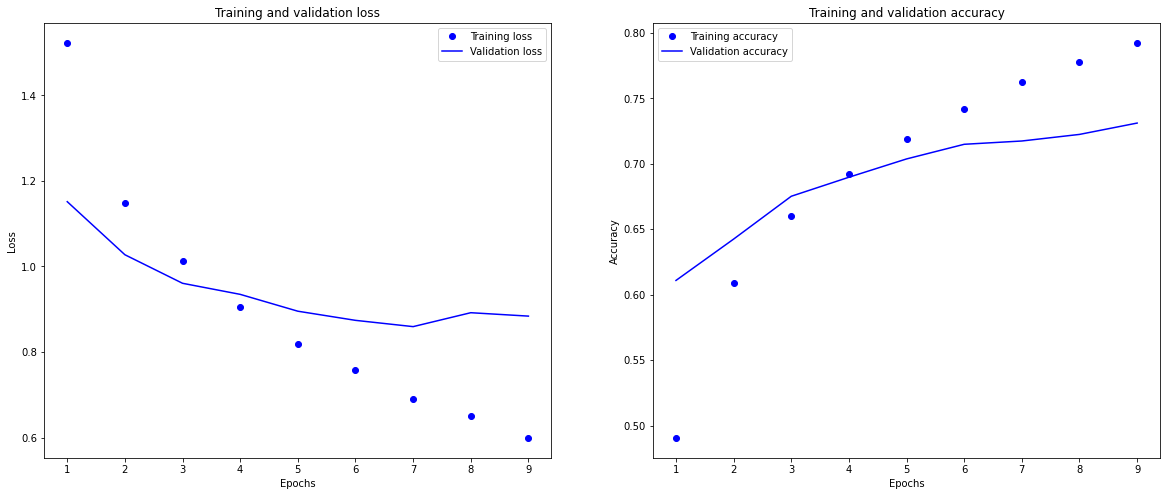

In [27]:
# Plotting the training and validation loss and accuracy
import matplotlib.pyplot as plt

fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (20, 8))

metrics = history.history
keys = list(metrics.keys())

loss_values = metrics[keys[0]] # loss
val_loss_values = metrics[keys[2]] # val_loss
epochs = range(1, len(metrics[keys[0]]) + 1)

ax1.plot(epochs, loss_values, 'bo', label='Training loss')
ax1.plot(epochs, val_loss_values, 'b', label='Validation loss')
ax1.set(title='Training and validation loss',
        xlabel='Epochs',
        ylabel='Loss')
ax1.legend()

acc_values = metrics[keys[1]] # accuracy
val_acc_values = metrics[keys[3]] # val_accuracy

ax2.plot(epochs, acc_values, 'bo', label='Training accuracy')
ax2.plot(epochs, val_acc_values, 'b', label='Validation accuracy')
ax2.set(title='Training and validation accuracy',
        xlabel='Epochs',
        ylabel='Accuracy')
ax2.legend()

plt.show()

## Avaliar precisão do modelo nos dados de teste

In [28]:
test_audio = []
test_labels = []

for audio, label in test_ds:
    test_audio.append(audio.numpy())
    test_labels.append(label.numpy())

test_audio = np.array(test_audio)
test_labels = np.array(test_labels)

In [29]:
y_pred = np.argmax(model.predict(test_audio), axis=1)
y_true = test_labels

test_acc = sum(y_pred == y_true) / len(y_true)
print(f'Test set accuracy: {test_acc:.2%}')

Test set accuracy: 74.56%


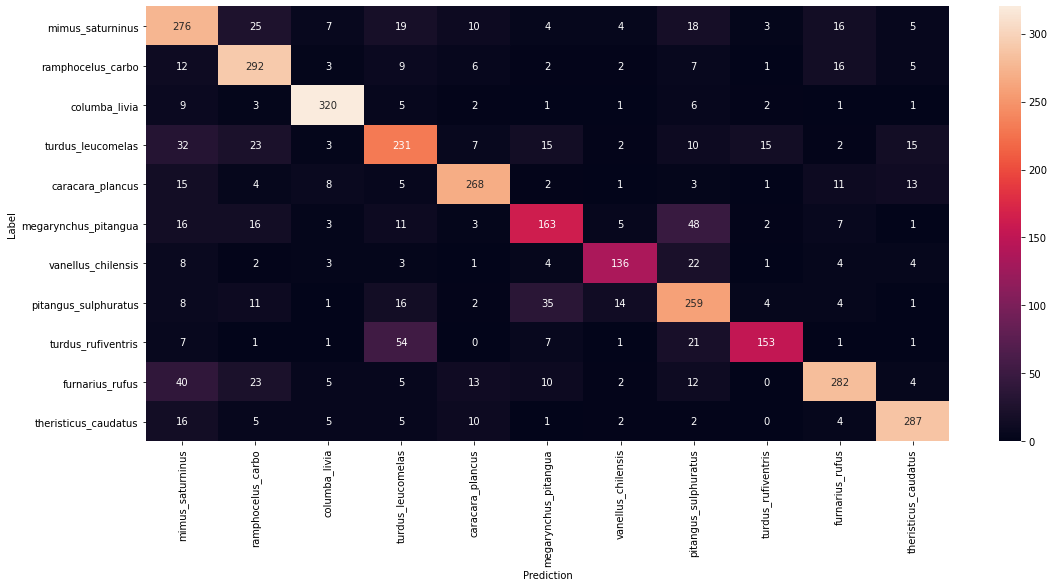

In [30]:
confusion_mtx = tf.math.confusion_matrix(y_true, y_pred) 
plt.figure(figsize=(18, 8))
sns.heatmap(confusion_mtx,
            xticklabels=especies,
            yticklabels=especies, 
            annot=True, fmt='g')
plt.xlabel('Prediction')
plt.ylabel('Label')
plt.show()

## Treinar modelo com todos os áudios

## Avaliar um único exemplar de áudio

In [31]:
#sample_file = '../audios/wav5s/caracaraplancus/Caracara587540-7.wav' #carcará
#sample_file = '../audios/wav5s/turdusrufiventris/Turdus586910-24.wav' #sabiá-laranjeira
#sample_file = '../audios/wav5seval/mimus_saturninus/Mimus645922-32.wav' #sabiá-do-campo
#sample_file = '../audios/wav5s/pitangussulphuratus/Pitangus552255-8.wav' #bem-te-vi
#sample_file = '../audios/wav5s/theristicuscaudatus/Theristicus503458-7.wav' #curicaca
#sample_file = '../audios/wav5s/columbalivia/Columba547588-10.wav' #pombo

sample_dir = 'eval/wav/'
#sample_file = sample_dir + 'theristicus_caudatus/357716-2.wav'
sample_file = sample_dir + 'cafeso/CAFESO_0227-tratado-8.wav'
#sample_file = sample_dir + 'theristicus_caudatus/XC288519-PESC1_7_Tcaud-3.wav'

In [32]:
waveform, label = get_waveform_and_label(sample_file)
print(label)
#print('Audio playback')
display.display(display.Audio(waveform, rate=16000))

tf.Tensor(b'cafeso', shape=(), dtype=string)


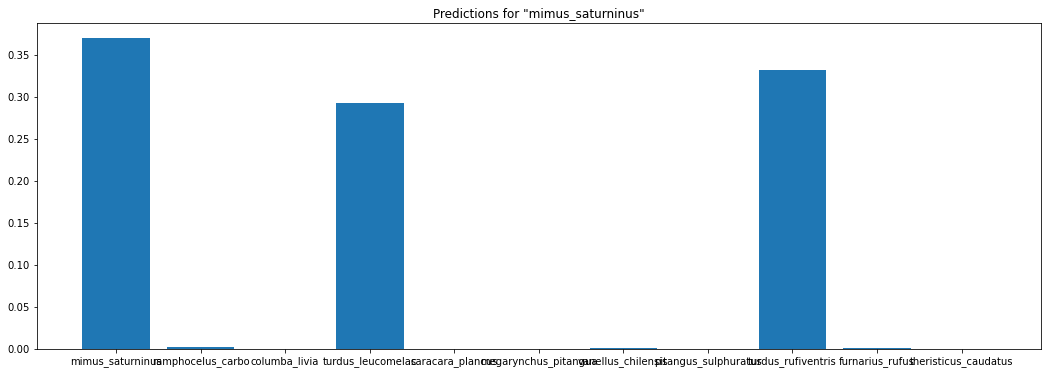

In [33]:
sample_ds = preprocess_dataset([str(sample_file)])

for spectrogram, label in sample_ds.batch(1):
    prediction = model(spectrogram)
    plt.figure(figsize=(18, 6))
    plt.bar(especies, tf.nn.softmax(prediction[0]))
    plt.title(f'Predictions for "{especies[label[0]]}"')
    plt.show()

## Avaliação de vários arquivos de uma única espécie

In [34]:
especies.tolist()

['mimus_saturninus',
 'ramphocelus_carbo',
 'columba_livia',
 'turdus_leucomelas',
 'caracara_plancus',
 'megarynchus_pitangua',
 'vanellus_chilensis',
 'pitangus_sulphuratus',
 'turdus_rufiventris',
 'furnarius_rufus',
 'theristicus_caudatus']

In [35]:
eval_specie = especies[8]
eval_specie

'turdus_rufiventris'

In [36]:
#eval_dir = pathlib.Path('wav/' + eval_specie)
eval_dir = pathlib.Path('eval/wav/cafeso')
#print(eval_dir)
eval_files = tf.io.gfile.glob(str(eval_dir) + '/*.wav')
eval_ds = preprocess_dataset(eval_files)
#batch_size = 64
#eval_ds = eval_ds.batch(batch_size)
#eval_ds = eval_ds.cache().prefetch(AUTOTUNE)
eval_ds

<ParallelMapDataset shapes: ((None, 129, 1), ()), types: (tf.float32, tf.int64)>

In [37]:
THRESHOLD = 0.3
value_sums = [0] * len(especies)
observations = len(eval_files)

for spectrogram, label in eval_ds.batch(1):
    prediction = model(spectrogram)
    values = tf.nn.softmax(prediction[0]).numpy()
    #print(values)
    
    for i in np.arange(len(especies)):
        value = values[i]
        value_sums[i] = value_sums[i] + value
        if value >= THRESHOLD:
            specie = especies[i]
            #print("%20s = %3.2f" % (specie, value * 100))
    #print('\n')

In [38]:
values = np.divide(value_sums, observations).tolist()
for i in np.arange(len(especies)):
    specie = especies[i]
    value = values[i]
    #print("%20s = %3.2f" % (specie, value * 100))

In [39]:
import pandas as pd

df = pd.DataFrame({
    'especie': especies,
    'probabilidade': np.multiply(values, 100)
})
df.sort_values(['probabilidade'], ascending=False).set_index(['especie'])

,probabilidade
especie,
turdus_leucomelas,36.315639
mimus_saturninus,35.205904
turdus_rufiventris,15.766097
ramphocelus_carbo,7.616410
furnarius_rufus,3.446926
vanellus_chilensis,0.868875
pitangus_sulphuratus,0.498915
theristicus_caudatus,0.140648
megarynchus_pitangua,0.120608
